In [31]:
import sys

sys.path.append('../../')
from global_variables import WORKSPACE

In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
def get_cgc_action(gene_action):

    if pd.isnull(gene_action):
        return "Ambiguous"
        
    gene_action = [action.strip() for action in gene_action.split(",")]

    if len(gene_action) == 1:
        if gene_action[0] == "oncogene":
            action = "Oncogene"
        elif gene_action[0] == "TSG":
            action = "Tumour suppressor"
        else:
            action = "Ambiguous"
        
    else:
        if "oncogene" in gene_action and "TSG" in gene_action:
            action = "Ambiguous"
        elif "oncogene" in gene_action:
            action = "Oncogene"
        elif "TSG" in gene_action:
            action = "Tumour suppressor"
        else:
            action = "Ambiguous"
    
    return action


cgc_df = pd.read_csv(f"{WORKSPACE}/projects/clustering_3d/o3d_analysys/datasets/input/cancer_202404/CGC_list_v99.tsv", sep = "\t")
cgc_df = cgc_df[["Gene Symbol", "Role in Cancer"]].rename(columns={
    "Gene Symbol" : "Gene", 
    "Role in Cancer" : "Gene_action"})
cgc_df.Gene_action = cgc_df.Gene_action.apply(lambda x: get_cgc_action(x))
cgc_df = cgc_df.assign(Gene=cgc_df['Gene'].str.split(','))
cgc_df = cgc_df.explode('Gene')
cgc_df['Gene'] = cgc_df['Gene'].str.strip()
cgc_df

,Gene,Gene_action
0,A1CF,Oncogene
1,ABI1,Tumour suppressor
2,ABL1,Oncogene
3,ABL2,Oncogene
4,ACKR3,Oncogene
...,...,...
738,ZNF429,Ambiguous
739,ZNF479,Ambiguous
740,ZNF521,Oncogene
741,ZNRF3,Tumour suppressor


In [147]:
def get_all_o3d_gene_result(cohort_df, o3d_output_dir, maf_input_dir, min_n=False, rank=False):

    lst_df = []
    n_dict = {}
    for cohort in cohort_df["COHORT"].values:
        cohort = "TCGA_WXS_SOFT_TISSUE" if cohort == "TCGA_WXS_SARC" else cohort
        path_csv = f"{o3d_output_dir}/{cohort}/{cohort}.3d_clustering_genes.csv"
        path_input_mut = f"{maf_input_dir}/{cohort}.in.maf"
        if os.path.exists(path_csv):
            df_o3d = pd.read_csv(path_csv, low_memory=False)
            df_o3d = df_o3d[["Gene", "Uniprot_ID", "Cohort", "pval", "qval", "Score_obs_sim_top_vol", "Mut_in_top_vol", "Mut_in_gene"]].dropna(subset=["pval"]).reset_index(drop=True)
            df_o3d = df_o3d[df_o3d["Mut_in_top_vol"] > 1].reset_index(drop=True)
            
            if rank:
                df_o3d = df_o3d.reset_index().rename(columns={"index": "Rank"})
            
            df_o3d.pval = df_o3d.pval.replace(0, 0.00001)
            df_mut = pd.read_table(path_input_mut, low_memory=False)
            df_mut = df_mut[df_mut["Variant_Classification"] == "Missense_Mutation"].reset_index(drop=True)
            df_mut = df_mut[df_mut.Hugo_Symbol.isin(df_o3d.Gene.unique())]
            
            if min_n != False:
                if len(df_o3d) > min_n:
                    lst_df.append(df_o3d)
            else:
                lst_df.append(df_o3d)
                
            n_dict[cohort] = {}
            n_dict[cohort]["genes"] = len(df_o3d)
            n_dict[cohort]["mut"] = len(df_mut)
        else:
            print(f"Path doesn't exist: {path_csv}")
            
    df = pd.concat(lst_df)
    df["n_genes"] = df.Cohort.map(lambda x: n_dict[x]["genes"])
    df["n_mut"] = df.Cohort.map(lambda x: n_dict[x]["mut"])
    df = df.sort_values(["n_genes", "pval"], ascending=[False, True])

    return df.reset_index(drop=True)

In [45]:
datasets = f"{WORKSPACE}/projects/clustering_3d/o3d_analysys/datasets/"
input_path = f"{datasets}/input/cancer_202404"
maf_input_dir = f"{input_path}/maf"

cohort_df = pd.read_csv(f"{input_path}/cohorts.tsv", sep="\t")
cohort_df = cohort_df[~cohort_df.COHORT.str.startswith("ICGC")].reset_index(drop=True)

In [53]:
RUN = "run_2024-07-01_16-04-14"
SUBDIR = "human_mane_raw"
o3d_output_dir_control = f"{datasets}/output/cancer_202404/o3d_output/{SUBDIR}/{RUN}"

In [84]:
RUN = "run_control_2025-03-21_11-24-24"
SUBDIR = "review"
o3d_output_dir_control = f"{datasets}/output/cancer_202404/o3d_output/{SUBDIR}/{RUN}"

In [85]:
RUN = "run_resbased_2025-05-16_14-18-44/"
SUBDIR = "review"
o3d_output_dir_resbase = f"{datasets}/output/cancer_202404/o3d_output/{SUBDIR}/{RUN}"

In [86]:
RUN = "run_nostd_2025-04-09_14-48-57/"
SUBDIR = "review"
o3d_output_dir_nostd = f"{datasets}/output/cancer_202404/o3d_output/{SUBDIR}/{RUN}"

## QQ-Plots

In [146]:
def qq_plot(
    df_results, 
    title=None, 
    filename=None, 
    figsize=(10, 16), 
    tcga=True, 
    title_fontsize=12, 
    cols=4,
    cgc_df=None,
    low_cut=True,
    thr_low=0.1,
    target_low="qval",
    high_cut=False,
    thr_high=1,
    target_high="pval",
    absolute=True
    ):
    
    rows = math.ceil(len(df_results.Cohort.unique()) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)
    axes = axes.flatten()

    cmap = plt.cm.rainbow  # Using the rainbow colormap

    for i, (cohort, df) in enumerate(df_results.groupby("Cohort", sort=False)):

        # Compute observed p-values and theoretical quantiles
        pvals = -np.log10(df.pval.values)
        n = len(pvals)
        expected = -np.log10(np.linspace(1/n, 1, n))
        ax = axes[i]
        
        # Normalize colors and sizes based on Mut_in_gene
        norm = plt.Normalize(df["Mut_in_gene"].min(), df["Mut_in_gene"].max())
        size_scale = (df["Mut_in_gene"] - df["Mut_in_gene"].min()) / (df["Mut_in_gene"].max() - df["Mut_in_gene"].min())
        marker_sizes = 10 + (size_scale * 100)  # Scale marker sizes between 10 and 100

        # Scatter plot with size and color based on "Mut_in_gene"
        ax.scatter(expected, pvals, c=df["Mut_in_gene"], cmap=cmap, norm=norm, s=marker_sizes, alpha=0.6, lw=0)
        
        # Expected line (y=x)
        x = np.linspace(*ax.get_xlim())
        ax.plot(x, x, color='black', linestyle='--', label='Expected Line (y=x)')

        # MLFC
        df_filtered = filter(df, cgc_df=cgc_df, thr_low=thr_low, thr_high=thr_high, target_low=target_low, target_high=target_high, low_cut=low_cut, high_cut=high_cut)
        score = mlfc(df_filtered.pval.values, absolute) 

        # Add labels and title for each subplot
        cohort = cohort.replace("TCGA_WXS_SOFT_TISSUE", "TCGA_WXS_SARC")
        cohort_name = cohort.split("_")[-1] if tcga else cohort
        ax.set_title(f'{cohort_name}\nMLFC = {score:.3f}', fontsize=title_fontsize)
        ax.set_xlabel(None)
        ax.set_ylabel(None)
    
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # Add color bar next to each subplot
        fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='vertical', 
                            fraction=1, pad=0.04)
        # cbar.set_label("Mutations in Gene")

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.supxlabel("Theoretical quantiles\n-log10(p-values)")
    fig.supylabel("Observed quantiles\n-log10(p-values)")
    if title:
        plt.suptitle(title, fontsize=14, y=1.02)

    if filename:
        plt.savefig(filename, dpi=600, bbox_inches='tight')
    plt.show()


def filter(
    df, 
    cgc_df=None, 
    low_cut=True, 
    thr_low=0.1, 
    target_low="qval", 
    high_cut=False, 
    thr_high=1, 
    target_high="pval"):

    if cgc_df is not None:
        df = df[~df["Gene"].isin(cgc_df.Gene)]
    if low_cut:
        df = df[df[target_low] >= thr_low].reset_index(drop=True)
    if high_cut:
        df = df[df[target_high] < thr_high].reset_index(drop=True)

    return df


def mlfc(pvals, absolute): 
    """
    mean absolute log2 fold change (MLFC) quantify the 
    differences between the observed P values and those 
    expected from a uniform distribution.

    If absolute = True, a general deviation from the uniform
    distribution is computed. If absolute = False, a positive 
    score indicate an overestimation of pvalues (p-values are 
    larger than expected), while a negative score indicate an 
    underestimation (p-values are lower than expected.)
    """

    pvals = np.sort(pvals)
    n = len(pvals)
    expected = np.linspace(min(pvals), max(pvals), n)
    if absolute:
        score = sum(abs(np.log2((pvals / expected)))) / n 
    else:
        score = sum(np.log2((pvals / expected))) / n 

    return score

In [148]:
df_results_control = get_all_o3d_gene_result(cohort_df, o3d_output_dir_control, maf_input_dir, min_n=1180) 
df_results_resbase = get_all_o3d_gene_result(cohort_df, o3d_output_dir_resbase, maf_input_dir, min_n=1180) 
df_results_nostd = get_all_o3d_gene_result(cohort_df, o3d_output_dir_nostd, maf_input_dir, min_n=1180) 

Path doesn't exist: /data/bbg/projects/clustering_3d/o3d_analysys/datasets//output/cancer_202404/o3d_output/review/run_control_2025-03-21_11-24-24/PEDCBIOP_WXS_TALL_REL/PEDCBIOP_WXS_TALL_REL.3d_clustering_genes.csv
Path doesn't exist: /data/bbg/projects/clustering_3d/o3d_analysys/datasets//output/cancer_202404/o3d_output/review/run_resbased_2025-05-16_14-18-44//PEDCBIOP_WXS_TALL_REL/PEDCBIOP_WXS_TALL_REL.3d_clustering_genes.csv
Path doesn't exist: /data/bbg/projects/clustering_3d/o3d_analysys/datasets//output/cancer_202404/o3d_output/review/run_nostd_2025-04-09_14-48-57//PEDCBIOP_WXS_TALL_REL/PEDCBIOP_WXS_TALL_REL.3d_clustering_genes.csv


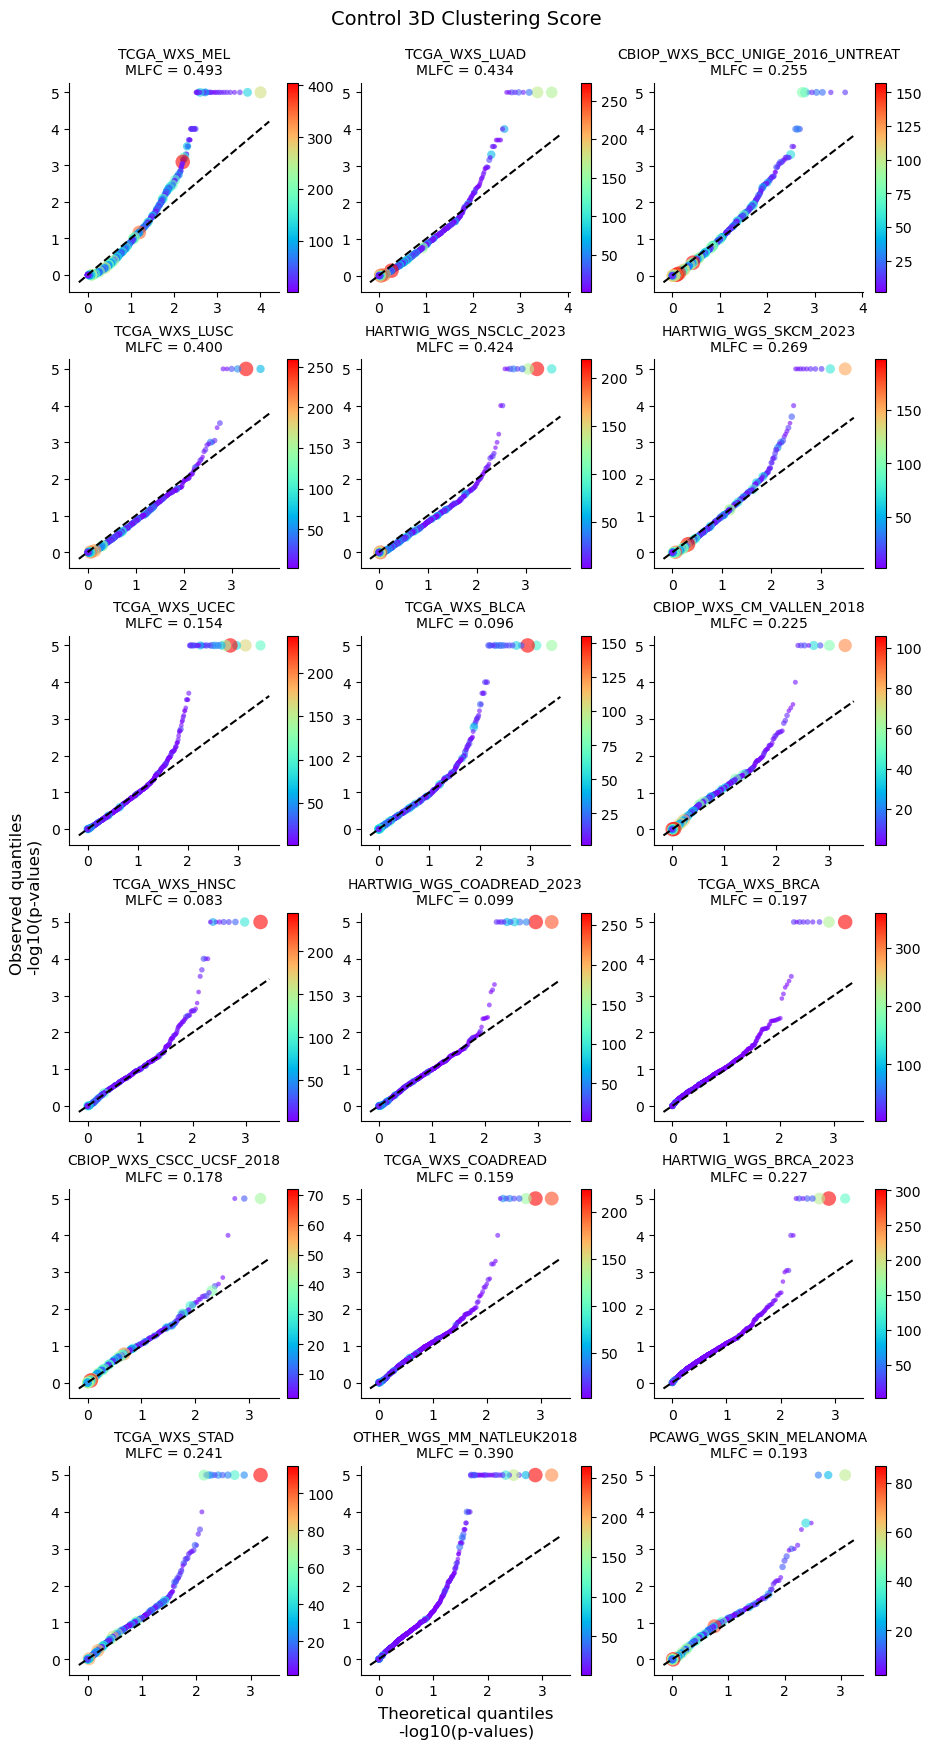

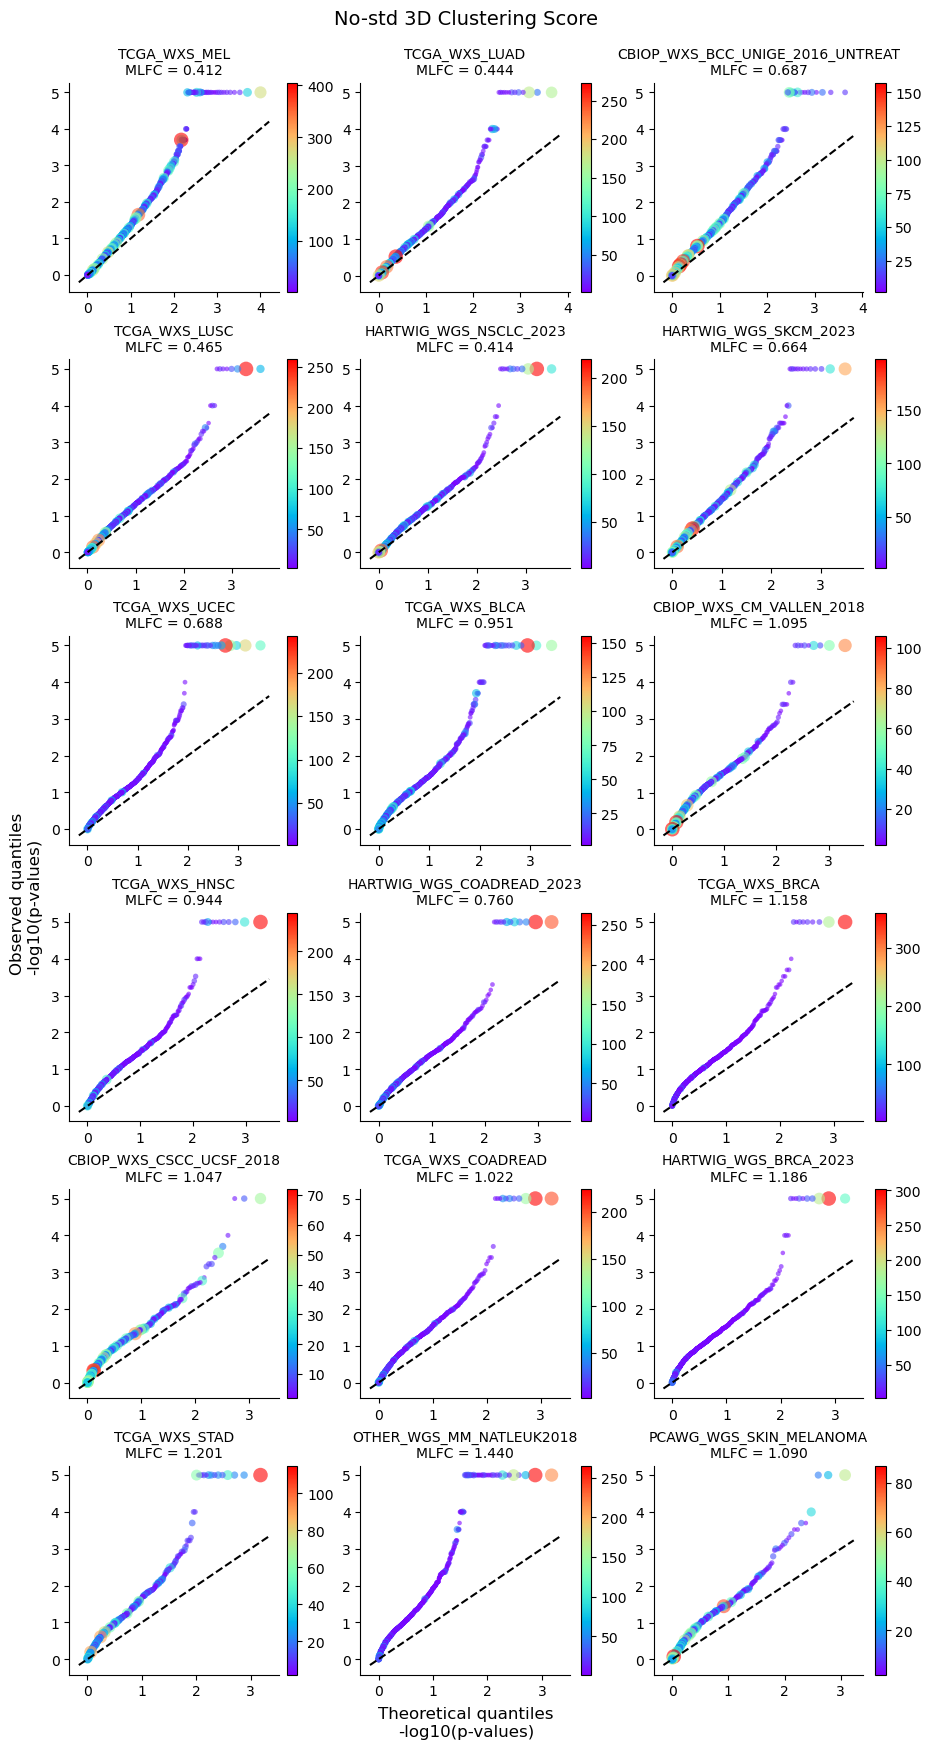

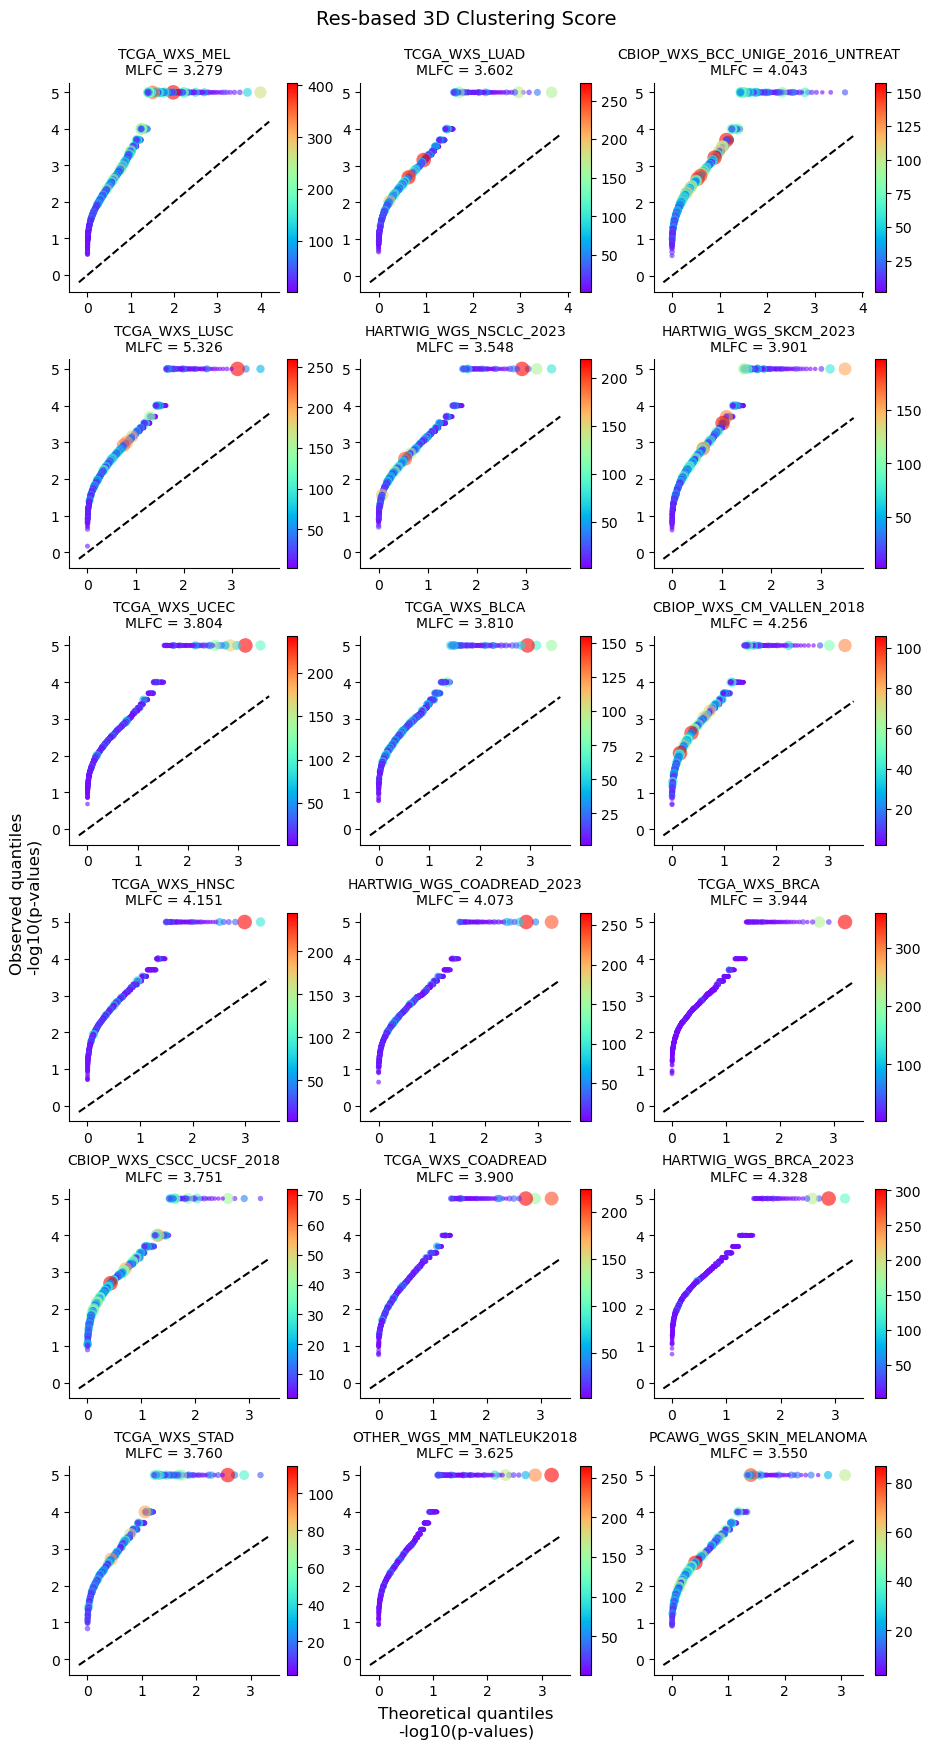

In [156]:
qq_plot(
    df_results_control, 
    title="Control 3D Clustering Score", 
    filename=None,
    figsize=(9.2, 17), 
    tcga=False, 
    title_fontsize=10, 
    cols=3,
    cgc_df=cgc_df,
    low_cut=True,
    thr_low=0.01,
    target_low="qval",
    high_cut=False,
    absolute=True
    )

qq_plot(
    df_results_nostd, 
    title="No-std 3D Clustering Score", 
    filename=None,
    figsize=(9.2, 17), 
    tcga=False, 
    title_fontsize=10, 
    cols=3,
    cgc_df=cgc_df,
    low_cut=True,
    thr_low=0.01,
    target_low="qval",
    high_cut=False,
    absolute=True
    )

qq_plot(
    df_results_resbase, 
    title="Res-based 3D Clustering Score", 
    filename=None,
    figsize=(9.2, 17), 
    tcga=False, 
    title_fontsize=10, 
    cols=3,
    cgc_df=cgc_df,
    low_cut=True,
    thr_low=0.01,
    target_low="qval",
    high_cut=False,
    absolute=True
    )

## Venn

In [95]:
def get_all_o3d_res_result(cohort_df, o3d_output_dir):

    lst_df = []

    for cohort in cohort_df["COHORT"].values:
        cohort = "TCGA_WXS_SOFT_TISSUE" if cohort == "TCGA_WXS_SARC" else cohort
        path_csv = f"{o3d_output_dir}/{cohort}/{cohort}.3d_clustering_pos.csv"
        if os.path.exists(path_csv):
            df_o3d = pd.read_csv(path_csv, low_memory=False)
            cols = ["Cohort", "Gene", "Pos", "Mut_in_gene", "Mut_in_vol", "Score", "Score_obs_sim", "Rank", "pval", 'C', 'C_ext']
            df_o3d = df_o3d[cols].dropna(subset=["pval"]).reset_index(drop=True)
            df_o3d.pval = df_o3d.pval.replace(0, 0.00001)
            lst_df.append(df_o3d)
        # else:
        #     print(f"Path doesn't exist: {path_csv}")
            
    df = pd.concat(lst_df).reset_index(drop=True)

    return df


def get_all_o3d_gene_result(cohort_df, o3d_output_dir):

    lst_df = []
    for cohort in cohort_df["COHORT"].values:
        cohort = "TCGA_WXS_SOFT_TISSUE" if cohort == "TCGA_WXS_SARC" else cohort
        path_csv = f"{o3d_output_dir}/{cohort}/{cohort}.3d_clustering_genes.csv"
        if os.path.exists(path_csv):
            df_o3d = pd.read_csv(path_csv, low_memory=False)
            df_o3d = df_o3d[["Gene", "Uniprot_ID", "Cohort", "pval", "qval", "Score_obs_sim_top_vol", "Mut_in_top_vol", "Mut_in_gene", 'C_gene', 'C_pos']].dropna(subset=["pval"]).reset_index(drop=True)
            df_o3d.pval = df_o3d.pval.replace(0, 0.00001)
            lst_df.append(df_o3d)
        # else:
        #     print(f"Path doesn't exist: {path_csv}")
            
    df = pd.concat(lst_df)

    return df.reset_index(drop=True)

In [104]:
df_results_control = get_all_o3d_gene_result(cohort_df, o3d_output_dir_control) 
res_results_control = get_all_o3d_res_result(cohort_df, o3d_output_dir_control)
df_results_resbase = get_all_o3d_gene_result(cohort_df, o3d_output_dir_resbase)
res_results_resbase = get_all_o3d_res_result(cohort_df, o3d_output_dir_resbase)
df_results_nostd = get_all_o3d_gene_result(cohort_df, o3d_output_dir_nostd) 
res_results_nostd = get_all_o3d_res_result(cohort_df, o3d_output_dir_nostd)

In [106]:
print("Significant unique gene p-values:")
print("Rank-based", len(df_results_control[df_results_control["pval"] < 0.01].Gene.unique()))
print("Rank-based no-std", len(df_results_nostd[df_results_nostd["pval"] < 0.01].Gene.unique()))
print("Res-based", len(df_results_resbase[df_results_resbase["pval"] < 0.01].Gene.unique()))

print("\nSignificant gene-cohort p-values:")
print("Rank-based", len(df_results_control[df_results_control["pval"] < 0.01]))
print("Rank-based no-std", len(df_results_nostd[df_results_nostd["pval"] < 0.01]))
print("Res-based", len(df_results_resbase[df_results_resbase["pval"] < 0.01]))

print("\nSignificant unique gene q-values:")
print("Rank-based", len(df_results_control[df_results_control["qval"] < 0.01].Gene.unique()))
print("Rank-based no-std", len(df_results_nostd[df_results_nostd["qval"] < 0.01].Gene.unique()))
print("Res-based", len(df_results_resbase[df_results_resbase["qval"] < 0.01].Gene.unique()))

print("\nSignificant gene-cohort q-values:")
print("Rank-based", len(df_results_control[df_results_control["qval"] < 0.01]))
print("Rank-based no-std", len(df_results_nostd[df_results_nostd["qval"] < 0.01]))
print("Res-based", len(df_results_resbase[df_results_resbase["qval"] < 0.01]))

print("\nSignificant clusters-cohort p-values:")
print("Rank-based", len(res_results_control[res_results_control["pval"] < 0.01]))
print("Rank-based no-std", len(res_results_nostd[res_results_nostd["pval"] < 0.01]))
print("Res-based", len(res_results_resbase[res_results_resbase["pval"] < 0.01]))

Significant unique gene p-values:
Rank-based 1344
Rank-based no-std 2803
Res-based 14114

Significant gene-cohort p-values:
Rank-based 2105
Rank-based no-std 4174
Res-based 81822

Significant unique gene q-values:
Rank-based 273
Rank-based no-std 371
Res-based 4151

Significant gene-cohort q-values:
Rank-based 619
Rank-based no-std 762
Res-based 6760

Significant clusters-cohort p-values:
Rank-based 5872
Rank-based no-std 9295
Res-based 137071


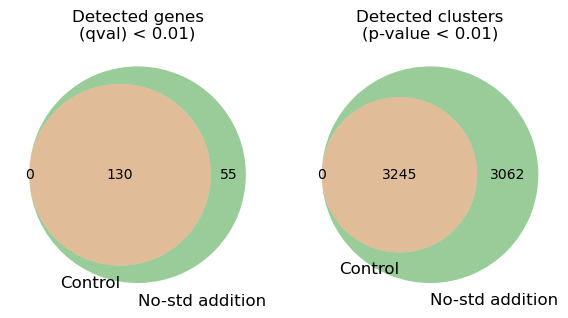

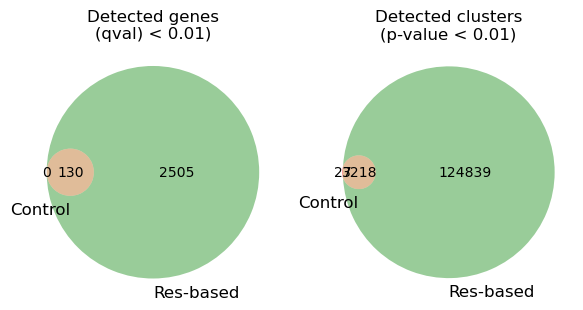

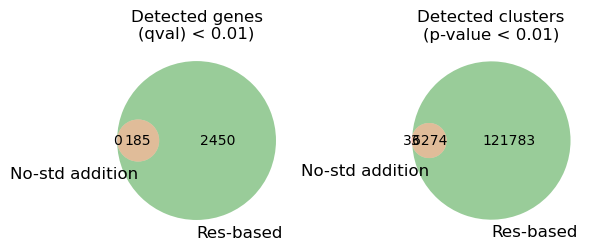

In [157]:
from matplotlib_venn import venn2

def plot_venn(df1, df2, df_res1, df_res2, title1="", title2="", label1="", label2=""):
    
    # Genes (qval)
    set1_genes_qval = set(df1[df1["qval"] < 0.01].Gene)
    set2_genes_qval = set(df2[df2["qval"] < 0.01].Gene)
    
    # Clusters (pval)
    set1_clusters = set(df_res1[df_res1["pval"] < 0.01][["Gene", "Pos"]]
                        .astype(str).agg(" | ".join, axis=1))
    set2_clusters = set(df_res2[df_res2["pval"] < 0.01][["Gene", "Pos"]]
                        .astype(str).agg(" | ".join, axis=1))
    

    fig, axes = plt.subplots(1, 2, figsize=(6, 5))

    # Venn diagrams
    venn2([set1_genes_qval, set2_genes_qval], set_labels=(label1, label2), ax=axes[0])
    axes[0].set_title("Detected genes\n(qval) < 0.01)")

    venn2([set1_clusters, set2_clusters], set_labels=(label1, label2), ax=axes[1])
    axes[1].set_title("Detected clusters\n(p-value < 0.01)")

    plt.tight_layout()
    plt.show()
    
plot_venn(
    df_results_control, df_results_nostd, 
    res_results_control, res_results_nostd,
    label1="Control", label2="No-std addition")

plot_venn(
    df_results_control, df_results_resbase, 
    res_results_control, res_results_resbase,
    label1="Control", label2="Res-based")

plot_venn(
    df_results_nostd, df_results_resbase, 
    res_results_nostd, res_results_resbase,
    label1="No-std addition", label2="Res-based")


/tmp/ipykernel_2515644/840693346.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


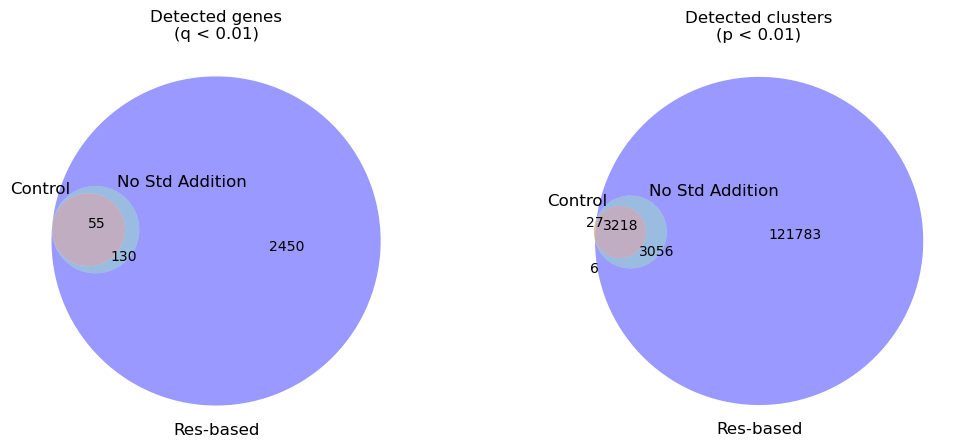

In [188]:
from matplotlib_venn import venn3


def spread_vertically(v, scale_up=1, scale_down=1, scale_left=1, scale_right=1):
    """
    For each subset‐label in the Venn:
      - If its y > 0, multiply by scale_up (push it further up)
      - If its y < 0, multiply by scale_down (push it further down)
    """
    for i, lbl in enumerate(v.subset_labels):
            if not lbl:
                continue
            x, y = lbl.get_position()
            # alternate
            yscale = scale_up if (i % 2 == 0) else scale_down
            xscale = scale_left if (i % 2 == 0) else scale_right
            lbl.set_position((x * xscale, y * yscale))
            

def plot_venn3(df1, df2, df3,
               df_res1, df_res2, df_res3,
               label1="", label2="", label3="",
               qval_thresh=0.01, pval_thresh=0.01):

    # — Genes (q-value)
    set1_genes = set(df1[df1["qval"] < qval_thresh].Gene)
    set2_genes = set(df2[df2["qval"] < qval_thresh].Gene)
    set3_genes = set(df3[df3["qval"] < qval_thresh].Gene)

    # — Clusters (p-value)
    make_cluster_set = lambda df: set(
        df[df["pval"] < pval_thresh][["Gene","Pos"]]
        .astype(str)
        .agg(" | ".join, axis=1)
    )
    set1_clust = make_cluster_set(df_res1)
    set2_clust = make_cluster_set(df_res2)
    set3_clust = make_cluster_set(df_res3)

    # — Plot
    fig, (ax1, ax2) = plt.subplots(
        1, 2, figsize=(12, 7),     
        gridspec_kw={'wspace': 0.4}
    )

    # Genes Venn
    v = venn3(
        [set1_genes, set2_genes, set3_genes],
        set_labels=(label1, label2, label3),
        ax=ax1
    )
    ax1.set_title(f"Detected genes\n(q < {qval_thresh})")
    spread_vertically(v, scale_up=-1.8, scale_down=1.8, scale_right=1.5)

    # Clusters Venn
    v = venn3(
        [set1_clust, set2_clust, set3_clust],
        set_labels=(label1, label2, label3),
        ax=ax2
    )
    ax2.set_title(f"Detected clusters\n(p < {pval_thresh})")
    spread_vertically(v, scale_up=1.8, scale_down=-1.8, scale_left=1)

    plt.tight_layout()
    # plt.subplots_adjust(wspace=0.4)
    plt.show()


# Example usage:
plot_venn3(
    df_results_control,
    df_results_nostd,
    df_results_resbase,     # your 3rd group
    res_results_control,
    res_results_nostd,
    res_results_resbase,    # your 3rd result‐set
    label1="Control",
    label2="No Std Addition",
    label3="Res-based"
)
